In [44]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from scipy.stats import mode
import pandas as pd
import numpy as np

## Скачиваем размеченный датасет с Kaggle

In [2]:
import kagglehub
import shutil
import os

def move_folder(source, destination):
    try:
        # Проверяем, существует ли исходная папка
        if not os.path.exists(source):
            print(f"Исходная папка '{source}' не найдена.")
            return 
        shutil.move(source, destination)
        print(f"Папка '{source}' успешно перемещена в '{destination}'.")
    except Exception as e:
        print(f"Произошла ошибка: {e}")

path = kagglehub.dataset_download("oussamabenhassine/epilepsy-detection-using-eeg-signals")
destination_folder = 'data'
move_folder(path, destination_folder)

Path to dataset files: C:\Users\Артём\.cache\kagglehub\datasets\oussamabenhassine\epilepsy-detection-using-eeg-signals\versions\1
Папка 'C:\Users\Артём\.cache\kagglehub\datasets\oussamabenhassine\epilepsy-detection-using-eeg-signals\versions\1' успешно перемещена в 'data'.


In [55]:
# Load data again
file_path = 'data/1/eeg_data.csv'
data = pd.read_csv(file_path)
data = data.rename(columns = {'epileptic_': 'target'})
data.shape

(2216, 668)

In [84]:
data.head()

,FP1_power_delta,FP1_power_theta,FP1_power_alpha,FP1_power_beta,FP1_power_gamma,FP2_power_delta,FP2_power_theta,FP2_power_alpha,FP2_power_beta,FP2_power_gamma,...,T5_STD_D4,T5_STD_D5,T5_STD_D6,T6_STD_D1,T6_STD_D2,T6_STD_D3,T6_STD_D4,T6_STD_D5,T6_STD_D6,target
0,15.980332,8.633358,3.092433,0.846559,0.372832,17.581626,9.937238,3.485713,0.945396,0.428797,...,31.427918,29.699413,32.013546,3.583559,12.529528,45.831132,61.890813,34.783454,33.245906,1.0
1,223.267803,41.573241,13.043525,6.463381,6.168712,298.274432,50.013025,14.411482,6.659230,4.942250,...,24.822720,47.185918,93.619195,14.158489,15.217886,30.927407,70.887317,117.733315,213.780950,1.0
2,158.673907,31.788608,9.956198,3.736977,2.926979,232.762741,39.332981,10.956081,3.478036,2.153082,...,21.708222,47.412375,85.729645,9.493639,11.824569,24.555772,59.229187,112.406306,171.618208,1.0
3,29.767326,3.875543,1.553127,0.438266,0.140495,45.206547,5.173542,2.028637,0.528962,0.161283,...,26.319506,39.628894,51.473202,1.872515,5.392639,17.296780,35.824586,44.892899,79.613460,1.0
4,33.821075,3.635210,1.347280,0.313205,0.080396,55.670043,4.925017,1.783729,0.394463,0.102254,...,26.111048,39.177537,52.925676,1.408291,4.556997,12.733549,25.676801,44.406617,94.770581,1.0


## Немного аналитики

In [115]:
first_5_columns = data.iloc[:, :4]
first_5_columns.head()

,FP1_power_delta,FP1_power_theta,FP1_power_alpha,FP1_power_beta
0,15.980332,8.633358,3.092433,0.846559
1,223.267803,41.573241,13.043525,6.463381
2,158.673907,31.788608,9.956198,3.736977
3,29.767326,3.875543,1.553127,0.438266
4,33.821075,3.635210,1.347280,0.313205


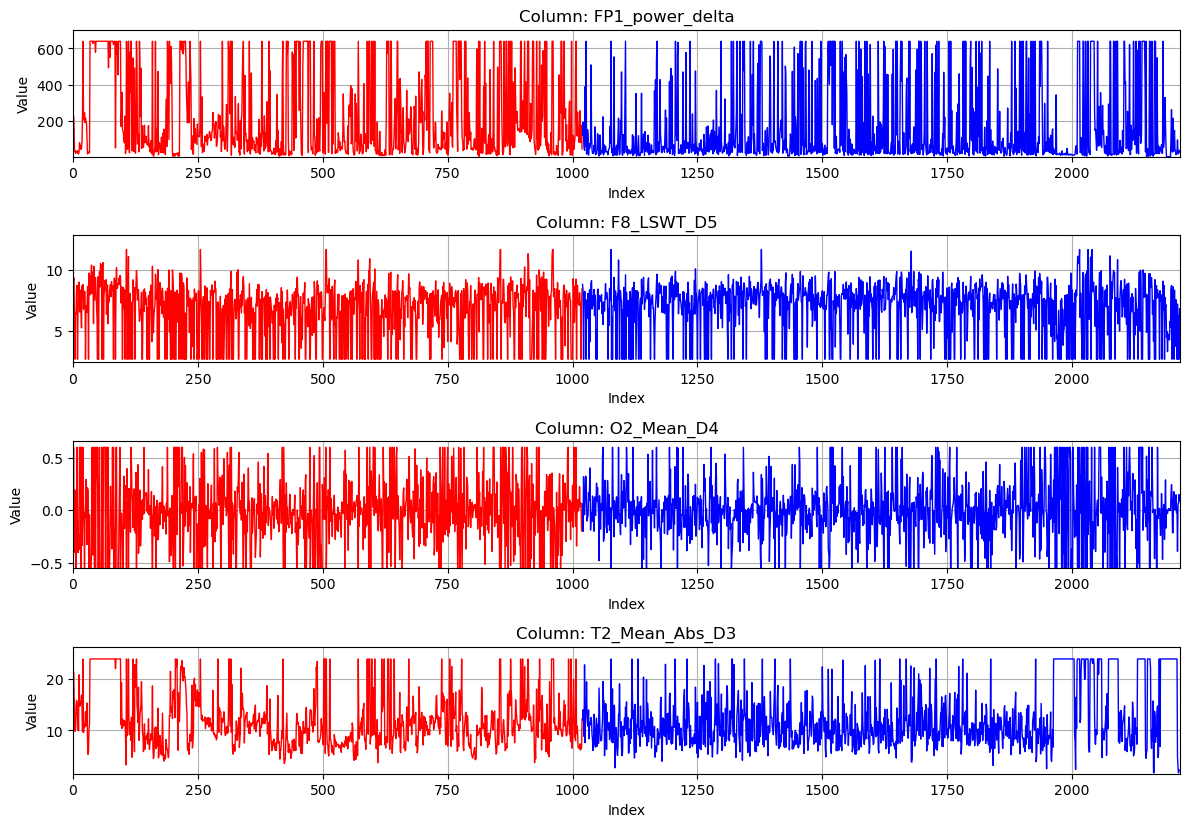

In [113]:
first_5_columns = data.iloc[:, ::668//(5-1)]

# Устанавливаем ограничения для осей
x_limit = (0, 2216)  # Пример: первые 500 значений
y_limit = (0, 100)  # Пример: значение по оси Y от 0 до 100

# Рисуем графики
plt.figure(figsize=(12, 10))

for i, col in enumerate(first_5_columns):
    plt.subplot(5, 1, i + 1)
#     plt.plot(data.index, data[col], 
#              color=np.where(data['target'] == 1, 'red', 'blue'), 
#              linestyle='-', linewidth=1)  # Убираем marker, оставляем линии
    
        # Разделяем данные по значению target
    plt.plot(data.index[data['target'] == 1], data[col][data['target'] == 1], 
             color='red', linestyle='-', linewidth=1, label='Target=1')
    
    plt.plot(data.index[data['target'] == 0], data[col][data['target'] == 0], 
             color='blue', linestyle='-', linewidth=1, label='Target=0')
    
    
    plt.title(f"Column: {col}")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.xlim(x_limit)  # Устанавливаем лимиты по оси X
    plt.ylim(data[col].min()*0.9, data[col].max()*1.1)  # Устанавливаем лимиты по оси Y
    plt.grid(True)

plt.tight_layout()
plt.show()

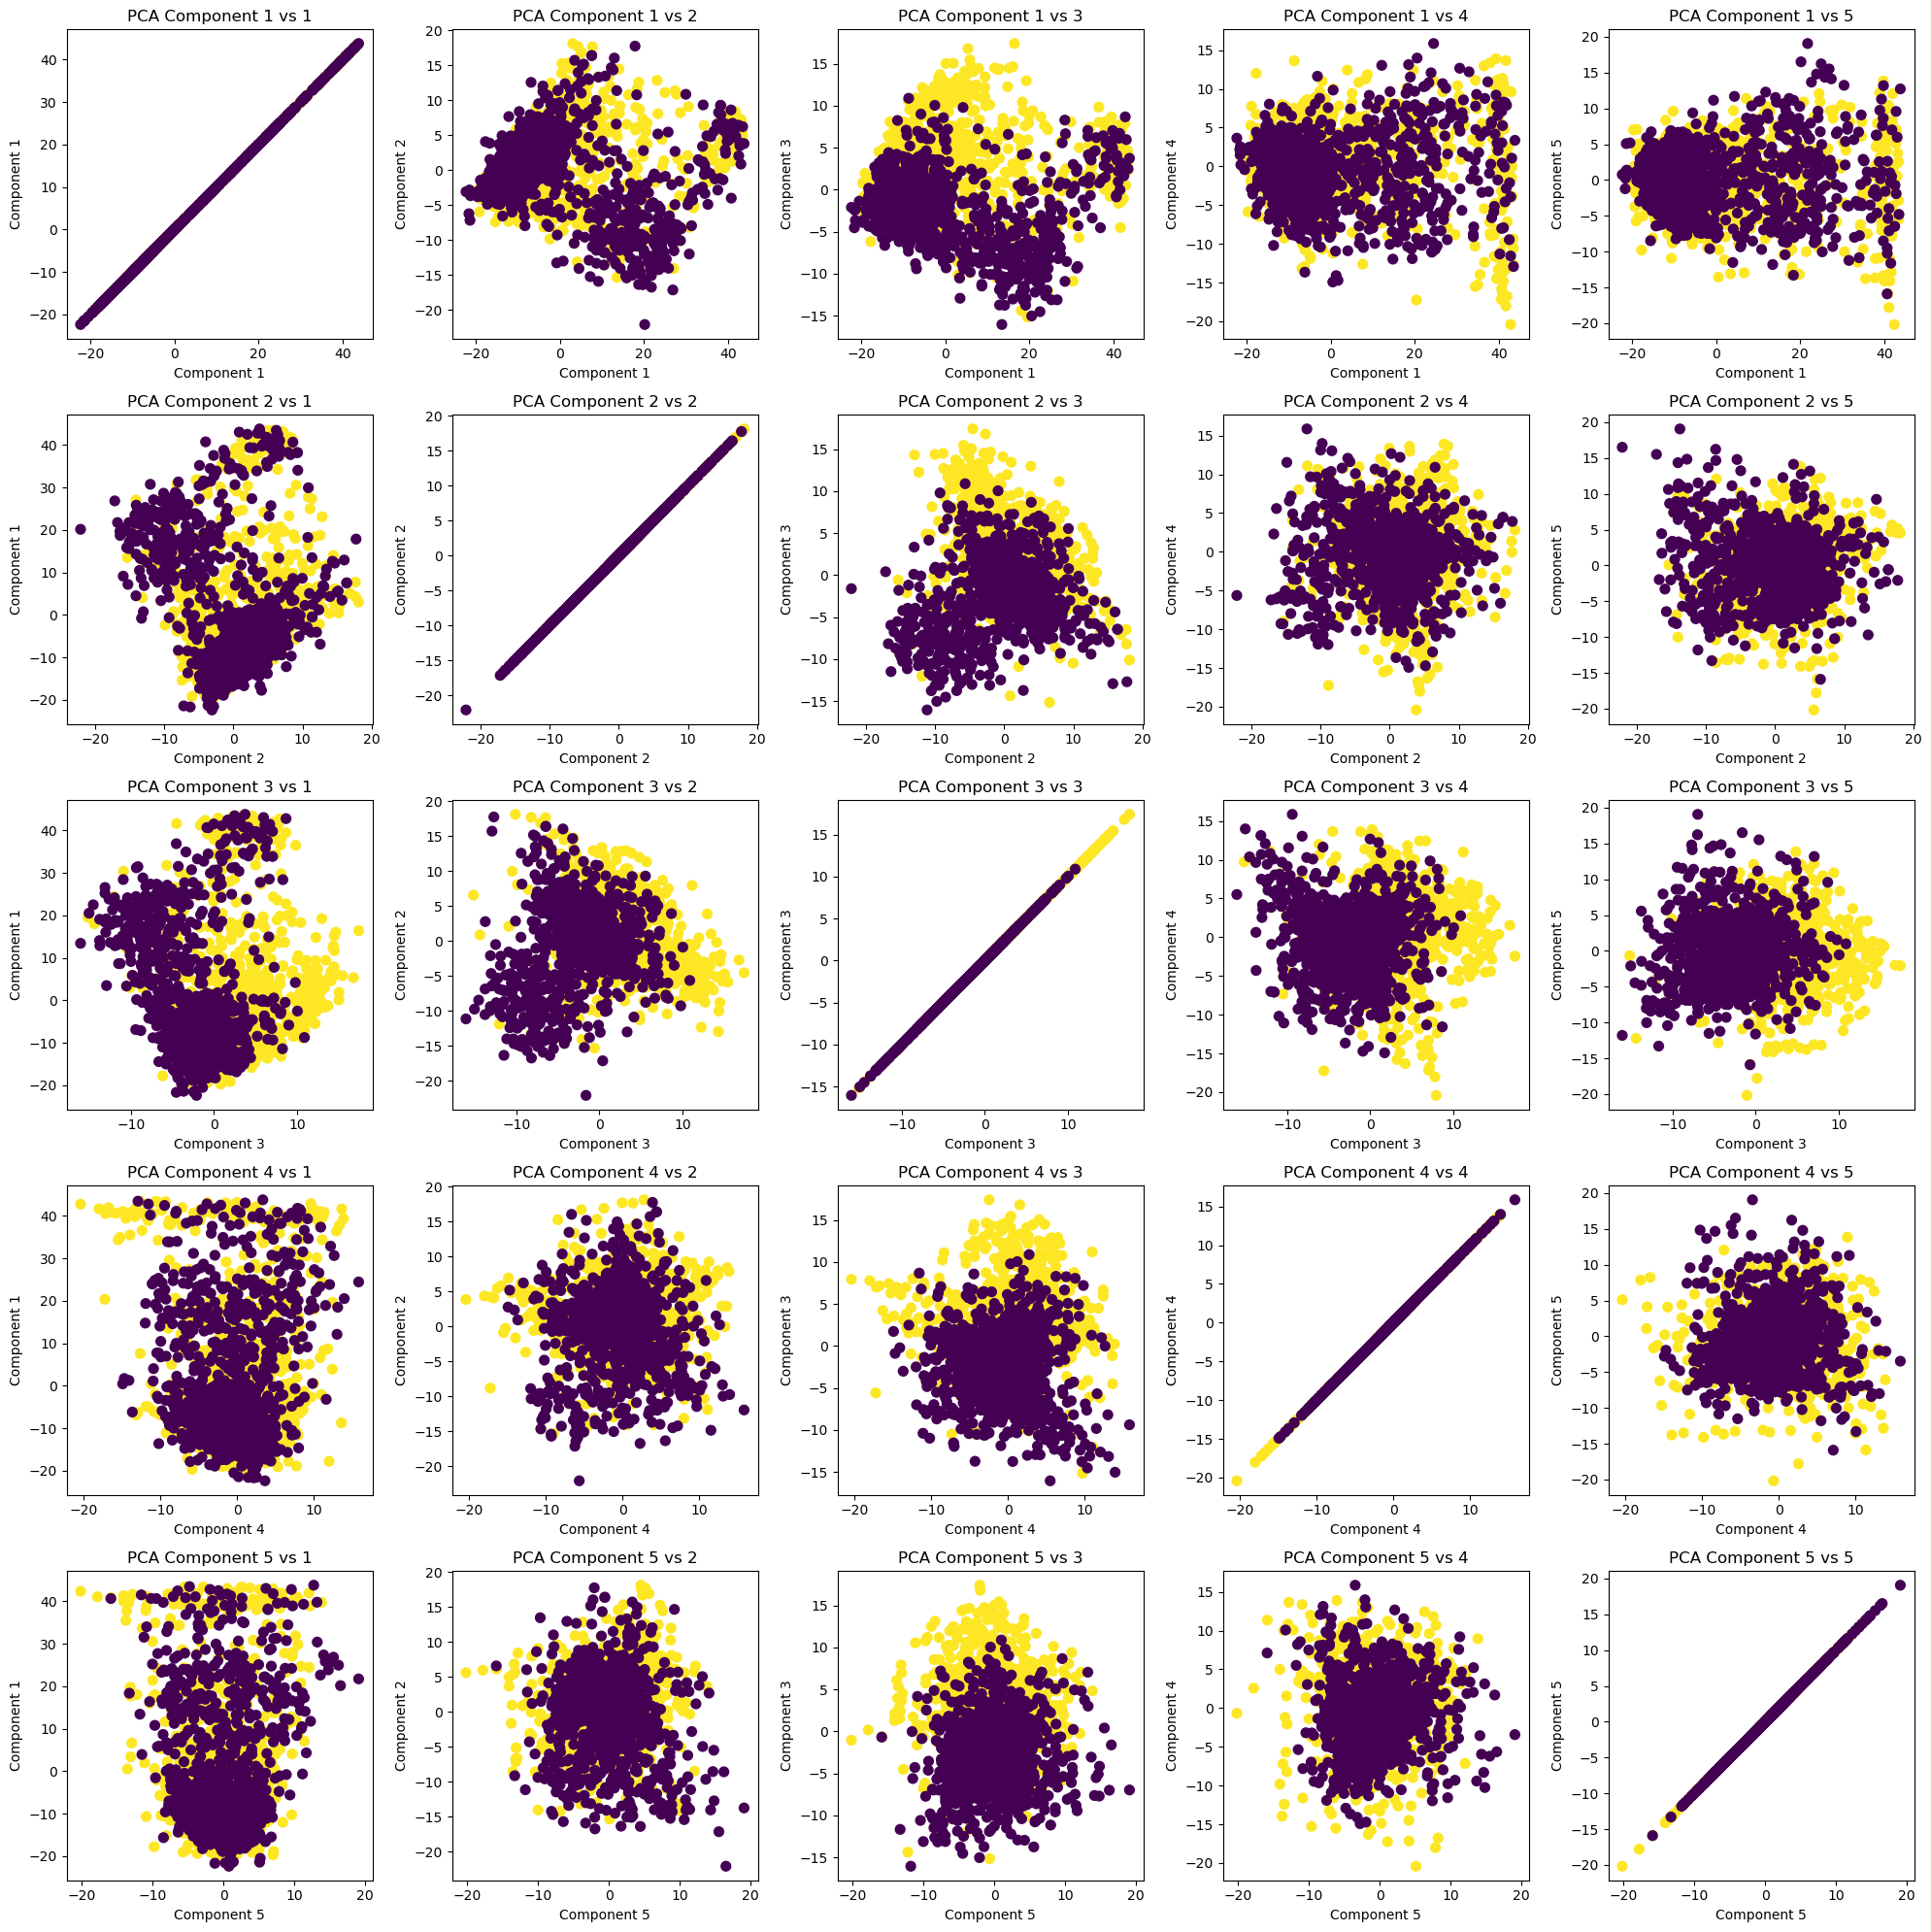

In [83]:
import matplotlib.pyplot as plt

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
X_pca.shape

# Создаем фигуру 5x5
fig, axes = plt.subplots(5, 5, figsize=(20, 20))

# Перебираем комбинации компонент для создания 25 графиков
component_pairs = [(i, j) for i in range(5) for j in range(5)]

for idx, (comp1, comp2) in enumerate(component_pairs):
    ax = axes[idx // 5, idx % 5]  # Определяем положение графика
    ax.scatter(X_pca[:, comp1], X_pca[:, comp2], c=y, cmap='viridis', s=50)
    ax.set_title(f"PCA Component {comp1+1} vs {comp2+1}")
    ax.set_xlabel(f"Component {comp1+1}")
    ax.set_ylabel(f"Component {comp2+1}")

# Добавляем пространство между графиками
plt.tight_layout()
plt.show()

### Заменяем выбросы на пороговое значение

In [63]:
def replace_outliers_with_max_threshold(df):
    for col in df.columns:
#         if df[col].dtype != np.object:  # Работать только с числовыми столбцами
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Заменяем выбросы на верхний порог
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
        # Заменяем выбросы на нижний порог, если нужно (опционально)
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    return df

# Применяем функцию
df_cleaned = replace_outliers_with_max_threshold(data)
df_cleaned.describe()

,FP1_power_delta,FP1_power_theta,FP1_power_alpha,FP1_power_beta,FP1_power_gamma,FP2_power_delta,FP2_power_theta,FP2_power_alpha,FP2_power_beta,FP2_power_gamma,...,T5_STD_D4,T5_STD_D5,T5_STD_D6,T6_STD_D1,T6_STD_D2,T6_STD_D3,T6_STD_D4,T6_STD_D5,T6_STD_D6,target
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,189.338243,21.601319,8.744493,4.676352,2.486455,196.383428,21.522165,8.892477,4.815727,2.534631,...,26.172389,39.747976,65.393246,8.449762,11.193331,21.179026,29.161434,43.741380,75.296869,0.460289
std,229.370537,24.880850,9.737226,5.557692,2.954481,236.567417,23.971400,9.690242,5.683009,2.988104,...,19.037415,34.555519,57.403754,6.684401,7.414445,14.053499,20.892261,37.045831,67.525723,0.498533
min,0.025945,0.012101,0.009409,0.007828,0.008412,0.026174,0.018836,0.010871,0.006120,0.006863,...,0.950777,1.057651,1.118569,0.525890,0.846936,0.878841,0.909989,0.918962,1.115070,0.000000
25%,25.524041,3.983245,1.868825,0.789355,0.381195,27.138890,4.254592,1.989122,0.845677,0.408081,...,12.298674,14.891381,23.835592,3.525874,5.796019,11.084702,14.190864,16.742939,26.750093,0.000000
50%,68.865751,8.807711,3.874506,1.795211,0.972968,73.483311,9.688978,4.133793,1.863871,0.973485,...,18.643405,23.730646,39.095777,5.855205,8.580373,15.806232,20.932141,27.049199,44.603975,0.000000
75%,271.174926,30.093458,12.052042,6.926863,3.777847,288.354575,29.503963,12.237335,7.139232,3.782326,...,32.798456,51.946562,84.372372,11.453332,14.326938,27.297323,36.869445,57.139089,101.925711,1.000000
max,639.651254,69.258778,27.326868,16.133126,8.872825,680.178103,67.378019,27.609655,16.579565,8.843695,...,63.548130,107.529335,175.177542,23.344519,27.123316,51.616254,70.887317,117.733315,214.689137,1.000000


### Предобработка

In [64]:
# Define your target column here (assuming the last column represents sleep phase labels)
# Replace 'Target' with the actual target column name for sleep phase classification
target_column = 'target'  # Placeholder name; replace with the actual column name

# Separate features and target
X = df_cleaned.drop(columns=[target_column])
y = df_cleaned[target_column]

In [65]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Опционально можно попробовать уменьшить количество признаков в моделе

In [73]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)
X_pca.shape

(2216, 50)

## KMeans

In [116]:
# K-Means clustering
kmeans = KMeans(n_clusters=2,
                init='k-means++', # random
                n_init= 2, # 'auto', 
                max_iter=300, 
                tol=0.0001, 
                verbose=0, 
                copy_x=True, 
                algorithm='lloyd') # elkan  
# Assuming binary clustering
kmeans.fit(X_pca)

# Predicted clusters
y_pred = kmeans.labels_

Смотрим метрики

In [117]:
print("Adjusted Rand Index (ARI):", adjusted_rand_score(y, y_pred))
print("Normalized Mutual Information (NMI):", normalized_mutual_info_score(y, y_pred))

Adjusted Rand Index (ARI): -0.0017420770525261196
Normalized Mutual Information (NMI): 0.0005933203955028775


In [118]:
y_pred_mapped = pd.Series(y_pred).map({0: 1, 1: 0})  # Example of remapping clusters

In [119]:
# Classification metrics
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred_mapped))
print("\nClassification Report:")
print(classification_report(y, y_pred_mapped))

Confusion Matrix:
[[290 906]
 [224 796]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.56      0.24      0.34      1196
         1.0       0.47      0.78      0.58      1020

    accuracy                           0.49      2216
   macro avg       0.52      0.51      0.46      2216
weighted avg       0.52      0.49      0.45      2216



## Кластеризация с ансаблями

In [70]:
# Define models
kmeans = KMeans(n_clusters=2, random_state=42)
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust parameters as needed
gmm = GaussianMixture(n_components=2, random_state=42)

# Fit models and predict clusters
kmeans_labels = kmeans.fit_predict(X_scaled)
dbscan_labels = dbscan.fit_predict(X_scaled)
gmm_labels = gmm.fit_predict(X_scaled)

# Handle -1 labels in DBSCAN (outliers)
dbscan_labels = np.where(dbscan_labels == -1, 0, dbscan_labels)  # Treat outliers as a separate cluster
# Combine predictions into a single array
ensemble_predictions = np.vstack((kmeans_labels, dbscan_labels, gmm_labels)).T

In [71]:
# Voting mechanism: mode of predictions
final_labels, _ = mode(ensemble_predictions, axis=1)
final_labels = final_labels.flatten()

# Evaluate ensemble clustering
print("Adjusted Rand Index (ARI):", adjusted_rand_score(y, final_labels))
print("Normalized Mutual Information (NMI):", normalized_mutual_info_score(y, final_labels))

# Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report

print("\nConfusion Matrix:")
print(confusion_matrix(y, final_labels))

print("\nClassification Report:")
print(classification_report(y, final_labels))

Adjusted Rand Index (ARI): -0.0016770053232308068
Normalized Mutual Information (NMI): 0.0005245107735199011

Confusion Matrix:
[[904 292]
 [793 227]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.76      0.62      1196
         1.0       0.44      0.22      0.29      1020

    accuracy                           0.51      2216
   macro avg       0.49      0.49      0.46      2216
weighted avg       0.49      0.51      0.47      2216



In [72]:
predictions = pd.DataFrame(data = {'kmeans':kmeans_labels, 'dbscan': dbscan_labels, 'gmm': gmm_labels})
predictions.sum(axis=0)

kmeans    519
dbscan      0
gmm       519
dtype: int64